In [1]:
import os
import pandas as pd
import janitor
import numpy as np

pd.set_option("display.max_columns", 100)

import seaborn as sns

sns.set_theme(
    context="notebook", font_scale=1.05, style="whitegrid", palette="dark"
)  #  Darkgrid Whitegrid Dark White Ticksimport matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from utils.utils import change_width, save_mpl_fig

FIGSAVEDIR = "../figs"
DATAPATH = "../adult-data/output"

In [2]:
# Read in list of classified FP (false positives)
falsepositives = pd.read_csv("../data/false_positives_list.csv")[
    "flagged as FP"
].tolist()
falsepositives

['9gag.com',
 'sniffies.com',
 'f95zone.to',
 'silverdaddies.com',
 'ttcache.com',
 'xlviirdr.com',
 '4chan.org',
 'thechive.com',
 'victoriassecret.com',
 'usasexguide.nl',
 'xlviiirdr.com',
 'xxxjmp.com',
 'urbandictionary.com',
 'lpsg.com']

In [3]:
# (fold cell) Load and prep web browsing data
usecols_web_desktop = ["caseid", "category", "private_domain", "visit_duration"]
usecols = ["caseid", "category", "private_domain", "page_duration"]

df = (
    pd.concat(
        [
            # Get web_mobile
            pd.read_csv(
                os.path.join(
                    DATAPATH, "realityMine_web_mobile_2022-06-01_2022-06-30.csv"
                ),
                usecols=usecols_web_desktop,
                low_memory=False,
            ),
            # Get web_desktop
            pd.read_csv(
                os.path.join(
                    DATAPATH, "realityMine_web_desktop_2022-06-01_2022-06-30.csv"
                ),
                usecols=usecols_web_desktop,
                low_memory=False,
            ),
            # Get web
            (
                pd.read_csv(
                    os.path.join(DATAPATH, "realityMine_web_2022-06-01_2022-06-30.csv"),
                    usecols=usecols,
                    low_memory=False,
                )
                # Renaming columns to be consistent w/ web_mobile & web_desktop
                .rename_column("page_duration", "visit_duration")
            ),
        ]
    )
    .query("category.str.contains('adult', case=False, na=False)")
    .query("private_domain not in @falsepositives")
    .dropna(subset=["caseid", "category", "visit_duration"])
)
print("output = df with visits to adult sites")
print(f"{len(df)=:,}")
df.head()

output = df with visits to adult sites
len(df)=84,289


,caseid,private_domain,category,visit_duration
266,201302005,adameve.com,"Adult, Shopping",482
292,201302005,adameve.com,"Adult, Shopping",2601
518,219344965,xhamster.com,Adult,258
1528,238181637,xvideos.com,Adult,373
1530,238181637,xvideos.com,Adult,449


In [4]:
# (fold cell) Get the top 25 adultsites by total duration of visits
df_top25_adult = (
    df.groupby(["private_domain", "category"])["visit_duration"]
    .sum()
    .reset_index()
    .sort_values("visit_duration", ascending=False, ignore_index=True)
    .head(25)
    .assign(rank=lambda df: 1 + df.index)
    .filter(["private_domain", "rank"])
)
df_top25_adult

,private_domain,rank
0,xvideos.com,1
1,xnxx.com,2
2,pornhub.com,3
3,xhamster.com,4
4,onlyfans.com,5
5,literotica.com,6
6,rule34.xxx,7
7,youporn.com,8
8,motherless.com,9
9,redtube.com,10


In [5]:
# (fold cell) Load individual metadata
df_ind = pd.read_csv(
    "../data/individual_browsing_data.csv", usecols=["caseid", "party"]
)
df_ind.head(3)

,caseid,party
0,200661421,D
1,200686597,NaN
2,200953869,R


In [6]:
# Merge with top sites and individual metadata (for party)
df_plot_top10 = (
    df
    # Merge with individual metadata
    .merge(df_ind, how="left", on="caseid", validate="m:1")
    # Normalize seconds to mins
    .assign(
        visit_duration=lambda df: df.visit_duration / 60,
    )
    #     Collapse to individual-domain level
    .groupby(["caseid", "party", "private_domain"])["visit_duration"]
    .sum()
    .reset_index()
    # Merge with top 25 sites to get rank (by total visit duration)
    .merge(df_top25_adult, how="left", on="private_domain", validate="m:1")
    .assign(top10=lambda df: np.where(df["rank"] <= 10, "Top 10", "Others"))
)
print(f"{len(df_plot_top10)=}")
df_plot_top10.head()

len(df_plot_top10)=2437


,caseid,party,private_domain,visit_duration,rank,top10
0,296069,R,18exgfs.com,0.233333,NaN,Others
1,296069,R,aiohotzgirl.com,5.066667,NaN,Others
2,296069,R,allover30.com,3.500000,NaN,Others
3,296069,R,anilos.com,5.933333,NaN,Others
4,296069,R,bestsexphoto.info,2.933333,NaN,Others


Top 10 = 109.3522309711286
Others = 9.195654052185935


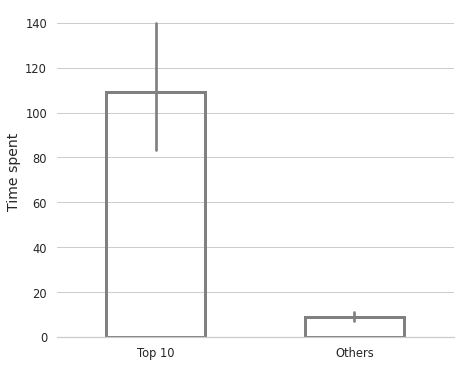

In [7]:
# (fold cell) Plot top 10 vs others
scale = 0.65
fig, ax = plt.subplots(figsize=(10 * scale, 8 * scale), facecolor="white")

sns.barplot(
    x="top10",
    y="visit_duration",
    data=df_plot_top10,
    order=["Top 10", "Others"],
    facecolor=(0, 0, 0, 0),
    linewidth=3,
    edgecolor=".5",
    errcolor=".5",
    ax=ax,
)
change_width(ax, 0.5)
ax.set_ylabel("Time spent", size=14)
ax.set_xlabel("", size=14)

sns.despine(left=True)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "concentration_porn_consumption"))

_mean = df_plot_top10.query("top10=='Top 10'").visit_duration.mean()
print(f"Top 10 = {_mean}")
_mean = df_plot_top10.query("top10=='Others'").visit_duration.mean()
print(f"Others = {_mean}")

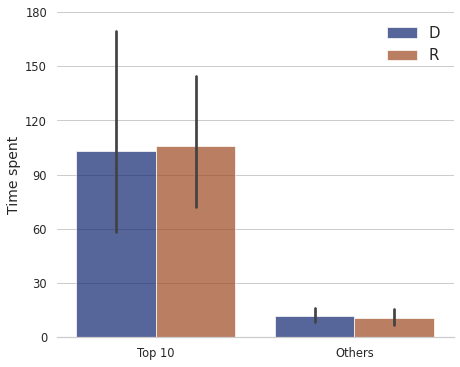

In [8]:
# (fold cell) Plot top 10 vs others by party
scale = 0.65
fig, ax = plt.subplots(figsize=(10 * scale, 8 * scale), facecolor="white")

sns.barplot(
    x="top10",
    y="visit_duration",
    data=df_plot_top10.query("party!='I'"),
    order=["Top 10", "Others"],
    hue="party",
    hue_order=["D", "R"],
    alpha=0.7,
    ax=ax,
)
ax.set_yticks(range(0, 200, 30))
legend = plt.legend()
plt.legend(fontsize=15, frameon=False)
ax.set_ylabel("Time spent", size=14)
ax.set_xlabel("", size=14)
sns.despine(left=True)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "concentration_porn_consumption_by_party"))

### Generalize that
* For each individual, get their ranked consumption
* So each individual will have 25 rows, one for each of their own top 25 adult sites, 

In [9]:
# (fold cell) Get top 10 sites per individual
df_results = pd.DataFrame()

for caseid in df["caseid"].unique():
    # Retrieve individual data
    _df_ind = (
        df
        #         .merge(df_ind[["caseid", "party"]], how="left", on="caseid", validate="m:1")
        # Collapse to individual-domain level
        .groupby(["caseid", "private_domain"])["visit_duration"]
        .sum()
        .reset_index()
        .query(f"caseid=={caseid}")
    )

    _df_ind_top10 = (
        _df_ind.sort_values("visit_duration", ascending=False, ignore_index=True)
        .assign(perc=lambda df: 100 * df["visit_duration"] / df["visit_duration"].sum())
        .reindex(labels=range(10))
        .assign(
            caseid=lambda df: df["caseid"].ffill().astype(int),
            #             party=lambda df: df["party"].ffill(),
            rank=lambda df: 1 + df.index,
            perc=lambda df: df["perc"].fillna(0),
        )
    )

    df_results = pd.concat([df_results, _df_ind_top10])
# # _df_ind_top10
df_results = df_results.merge(
    df_ind[["caseid", "party"]], how="left", on="caseid", validate="m:1"
)
df_results

,caseid,private_domain,visit_duration,perc,rank,party
0,201302005,adameve.com,6166.0,100.0,1,NaN
1,201302005,NaN,NaN,0.0,2,NaN
2,201302005,NaN,NaN,0.0,3,NaN
3,201302005,NaN,NaN,0.0,4,NaN
4,201302005,NaN,NaN,0.0,5,NaN
...,...,...,...,...,...,...
3605,250950981,NaN,NaN,0.0,6,D
3606,250950981,NaN,NaN,0.0,7,D
3607,250950981,NaN,NaN,0.0,8,D
3608,250950981,NaN,NaN,0.0,9,D


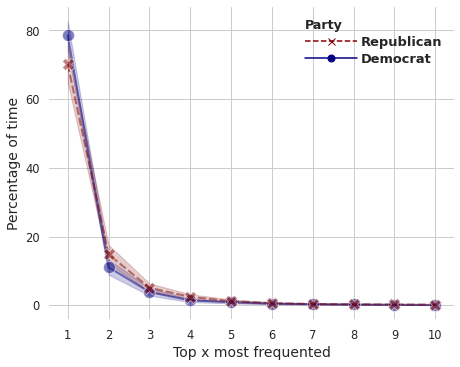

In [10]:
# (fold cell) plot
scale = 0.65
fig, ax = plt.subplots(figsize=(10 * scale, 8 * scale), facecolor="white")

sns.lineplot(
    x="rank",
    y="perc",
    data=df_results.query("party!='I'"),
    hue="party",
    style="party",
    markers=True,
    markersize=12,
    markeredgewidth=1,
    palette=["navy", "maroon"],
    lw=2,
    alpha=0.5,
    legend=False,
    ax=ax,
)
ax.set_xticks(range(1, 11))

ax.set_xlabel("Top x most frequented", size=14)
ax.set_ylabel("Percentage of time", size=14)

rep_hand = mlines.Line2D(
    [], [], color="maroon", marker="x", ls="--", markersize=7, label="Republican"
)
dem_hand = mlines.Line2D(
    [],
    [],
    color="navy",
    marker="o",
    ls="-",
    markersize=7,
    label="Democrat",
)
custom_legend = plt.legend(
    handles=[rep_hand, dem_hand],
    handlelength=4,
    handletextpad=0.3,
    labelspacing=0.3,
    title="Party",
    frameon=False,
    loc="best",
    prop={"weight": "bold", "size": 13},
)
custom_legend._legend_box.align = "left"
custom_legend.get_title().set_weight("bold")

sns.despine(left=True, bottom=True)
plt.tight_layout()
save_mpl_fig(os.path.join(FIGSAVEDIR, "concentration_porn_consumption_topX_by_party"))